# Importing Libraries and Loading Metadata

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.optimizers import Adam, Adamax
from keras.callbacks import EarlyStopping , ModelCheckpoint
import math
import seaborn as sns
%matplotlib inline


path_metadata = r'Data\HAM10000_metadata.csv'
path_to_Image_Folder = r'Data'

Metadata = pd.read_csv(path_metadata)
Metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


# Exploratory Data Analysis

In [2]:
print(Metadata['lesion_id'].value_counts())

lesion_id
HAM_0003789    6
HAM_0000835    6
HAM_0005263    6
HAM_0001863    6
HAM_0007427    5
              ..
HAM_0006000    1
HAM_0002762    1
HAM_0006894    1
HAM_0007132    1
HAM_0003347    1
Name: count, Length: 7470, dtype: int64


In [3]:
print('length of Dataset: ',len(Metadata))
print('Disease Types: \n',Metadata['dx'].unique())
print('Number of images of each disease: \n',Metadata['dx'].value_counts())
print('Unique values of dx_type: ',Metadata['dx_type'].unique())
print('Unique values of localization: ',Metadata['localization'].unique())
print('Number of images of each disease: \n',Metadata['dx'].value_counts())
print('minimum age: ',Metadata['age'].min())
print('maximum age: ',Metadata['age'].max())


length of Dataset:  10015
Disease Types: 
 ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Number of images of each disease: 
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
Unique values of dx_type:  ['histo' 'consensus' 'confocal' 'follow_up']
Unique values of localization:  ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']
Number of images of each disease: 
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
minimum age:  0.0
maximum age:  85.0


In [4]:
print('Any missing values: ',Metadata.isnull().values.any())
print('Number of missing values: ',Metadata.isnull().sum().sum())
print('Missing values in each column: \n',Metadata.isnull().sum())
print('Number of unknown values in each column: \n',Metadata[Metadata=='unknown'].count())
print('Unique values of Age: ',Metadata['age'].unique())

Any missing values:  True
Number of missing values:  57
Missing values in each column: 
 lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
dtype: int64
Number of unknown values in each column: 
 lesion_id         0
image_id          0
dx                0
dx_type           0
age               0
sex              57
localization    234
dataset           0
dtype: int64
Unique values of Age:  [80. 75. 60. 70. 55. 85. 65. 40. 50. 45. 35.  0. 30. nan  5. 25. 20. 10.
 15.]


Text(0.5, 1.0, 'Countplot For Disease Classes')

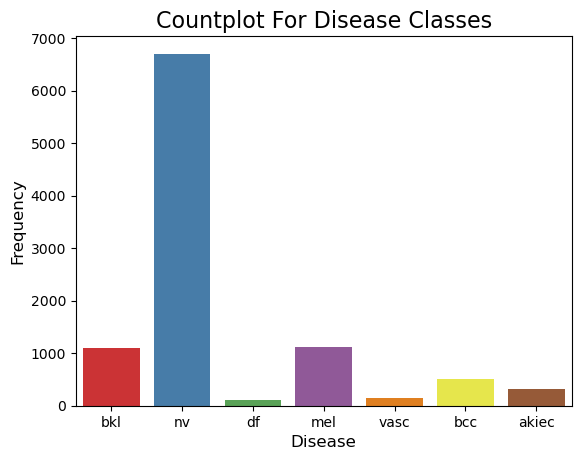

In [5]:
sns.countplot(x = 'dx', data = Metadata, palette = 'Set1')
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Countplot For Disease Classes', size=16)

Text(0.5, 1.0, 'Age Distribution')

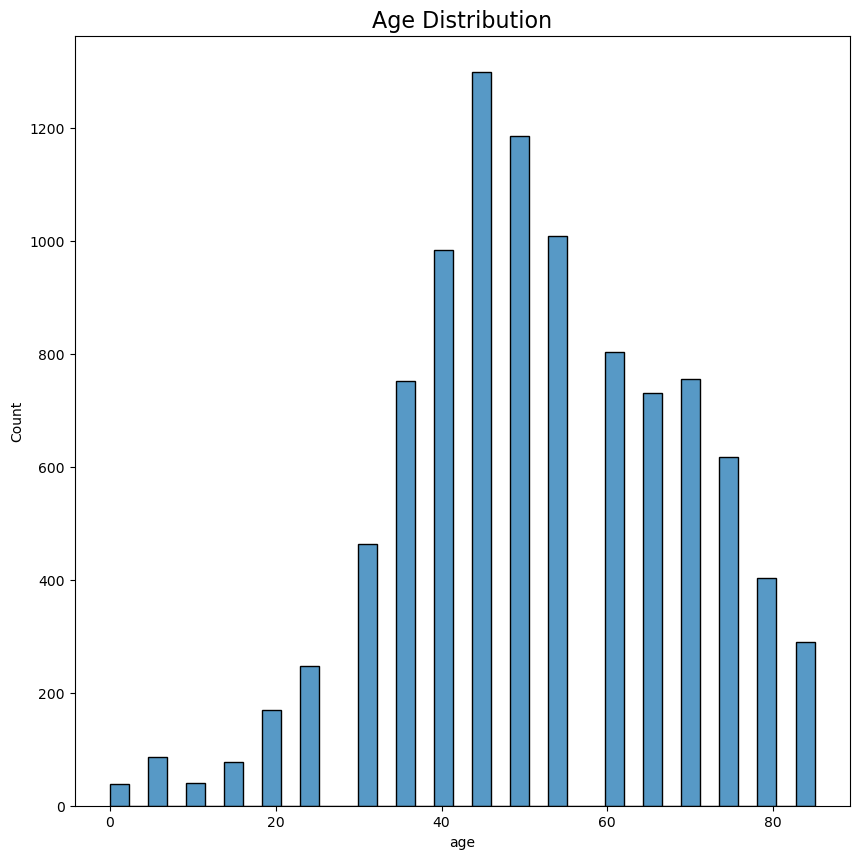

In [6]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(Metadata['age'])
plt.title('Age Distribution', size=16)

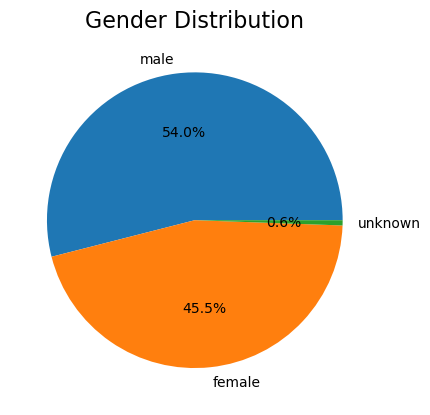

In [7]:
plt.pie(Metadata['sex'].value_counts(), labels = Metadata['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender Distribution', size=16);

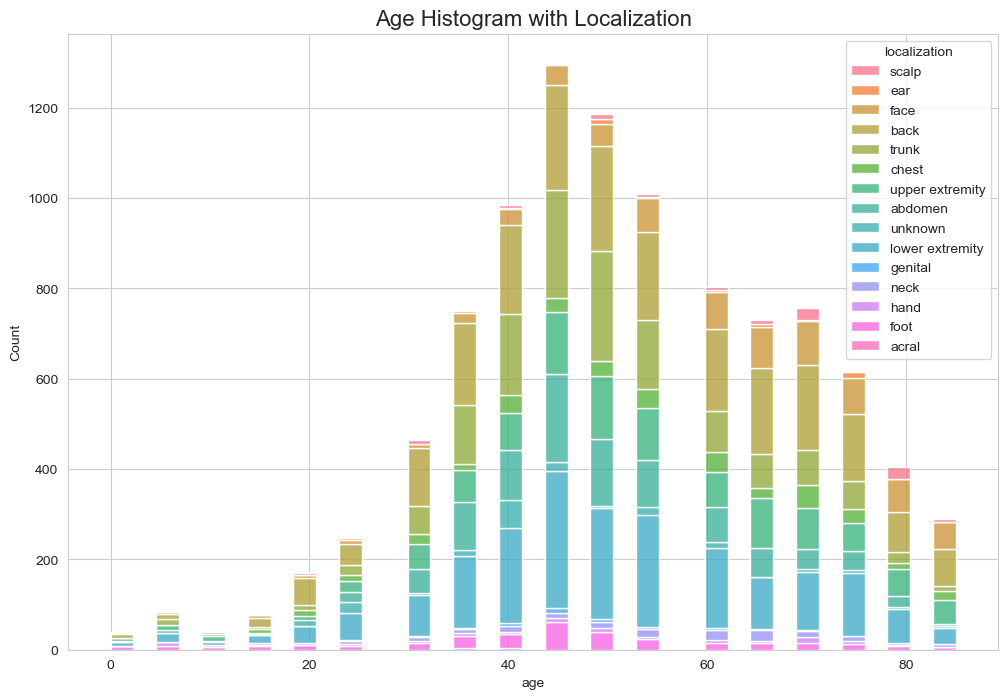

In [8]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=Metadata, x='age',hue='localization',multiple='stack')
plt.title('Age Histogram with Localization', size=16)
plt.show()

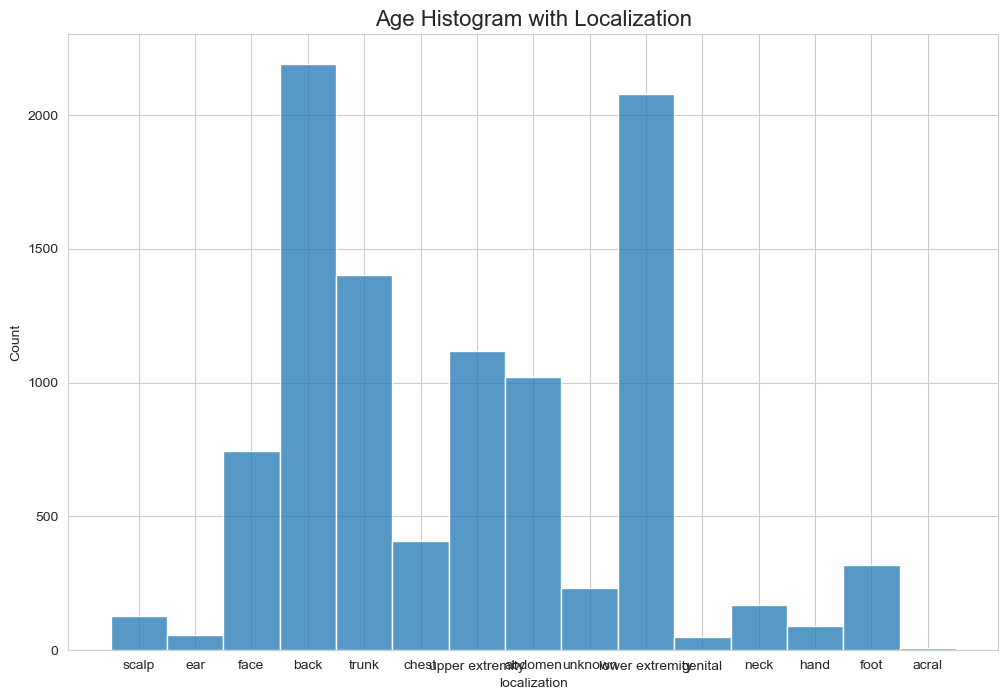

In [9]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=Metadata, x='localization',
                  multiple='stack')
plt.title('Age Histogram with Localization', size=16)
plt.show()

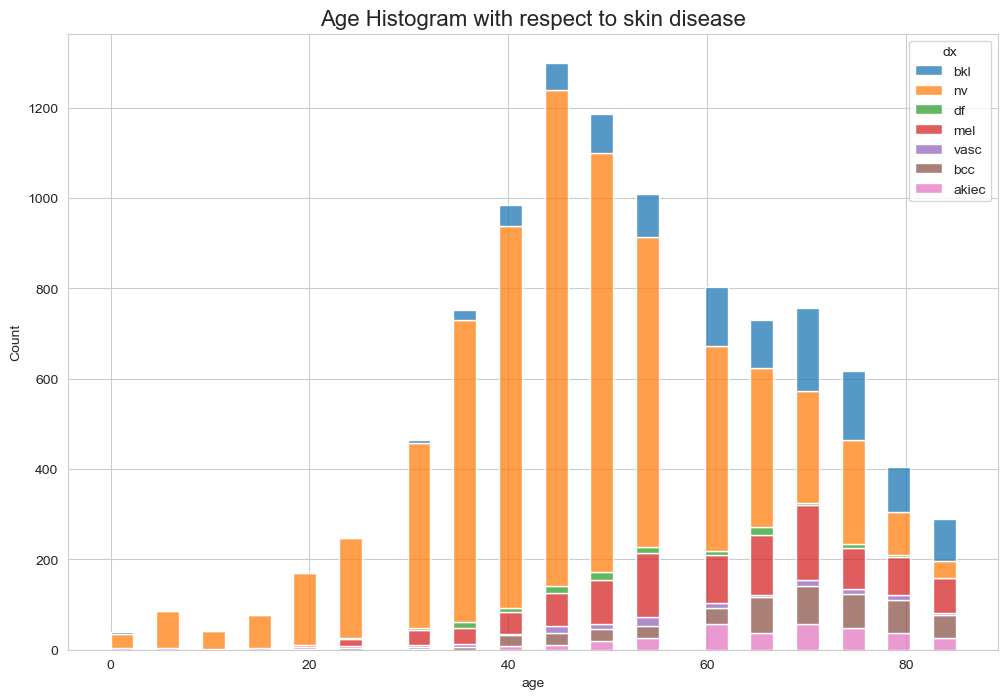

In [10]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=Metadata, x='age',hue='dx',multiple='stack')
plt.title('Age Histogram with respect to skin disease', size=16)
plt.show()

(450, 600, 3)


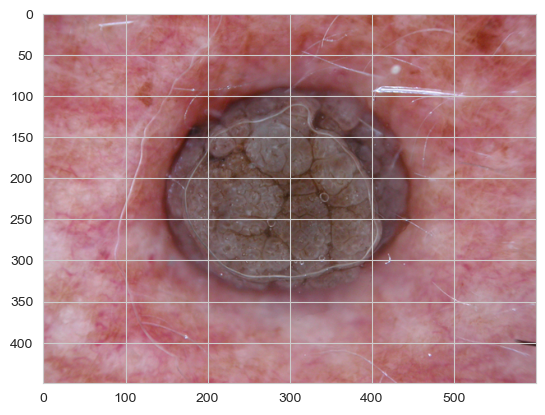

In [12]:
fpath=r'Data\ISIC_0034303.jpg'
img=plt.imread(fpath)
print (img.shape)
plt.imshow(img)

# Loading the Images

In [14]:
# Initialize the Image List
Image_List = []

for path_dir, dir_names, filenames in os.walk(path_to_Image_Folder):
    # Loop over the sub directories to get the images
    for filename in filenames:
        # Check if the image is a jpg file
        if filename.endswith('.jpg'):
            # Read the image using cv2
            img = cv2.imread(os.path.join(path_dir, filename), cv2.IMREAD_UNCHANGED)
            
            # Normalizing the image
            img = img / 255.0

            # Resizing the image to (256, 256, 3)
            img = cv2.resize(img, (256, 256))

            # Appending the image to the list
            Image_List.append([filename.split('.')[0], img])

# Convert the Image List to a DataFrame directly
Image_List_df = pd.DataFrame(Image_List, columns=['image_id', 'image'])

# Print the DataFrame head and shape
print(Image_List_df.head())
print(Image_List_df.shape)

       image_id                                              image
0  ISIC_0024306  [[[0.49957634420955876, 0.5068426393995098, 0....
1  ISIC_0024307  [[[0.5241653741574754, 0.48271316827512256, 0....
2  ISIC_0024308  [[[0.7100643382352941, 0.674747003293505, 0.96...
3  ISIC_0024309  [[[0.5329345703125, 0.4747448491115196, 0.8227...
4  ISIC_0024310  [[[0.1448096181832108, 0.13337139054840685, 0....
(10015, 2)


In [16]:
# Merging the Metadata and Image Dataframes
Metadata = Metadata.merge(Image_List_df, on='image_id', how='inner')
Metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,"[[[0.7497168447457108, 0.5840738932291667, 0.7..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,"[[[0.08507702397365195, 0.052729348575367645, ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,"[[[0.5320492015165441, 0.49996409696691174, 0...."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,"[[[0.059622730928308824, 0.04153885186887255, ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,"[[[0.40775385837928924, 0.32196691176470593, 0..."


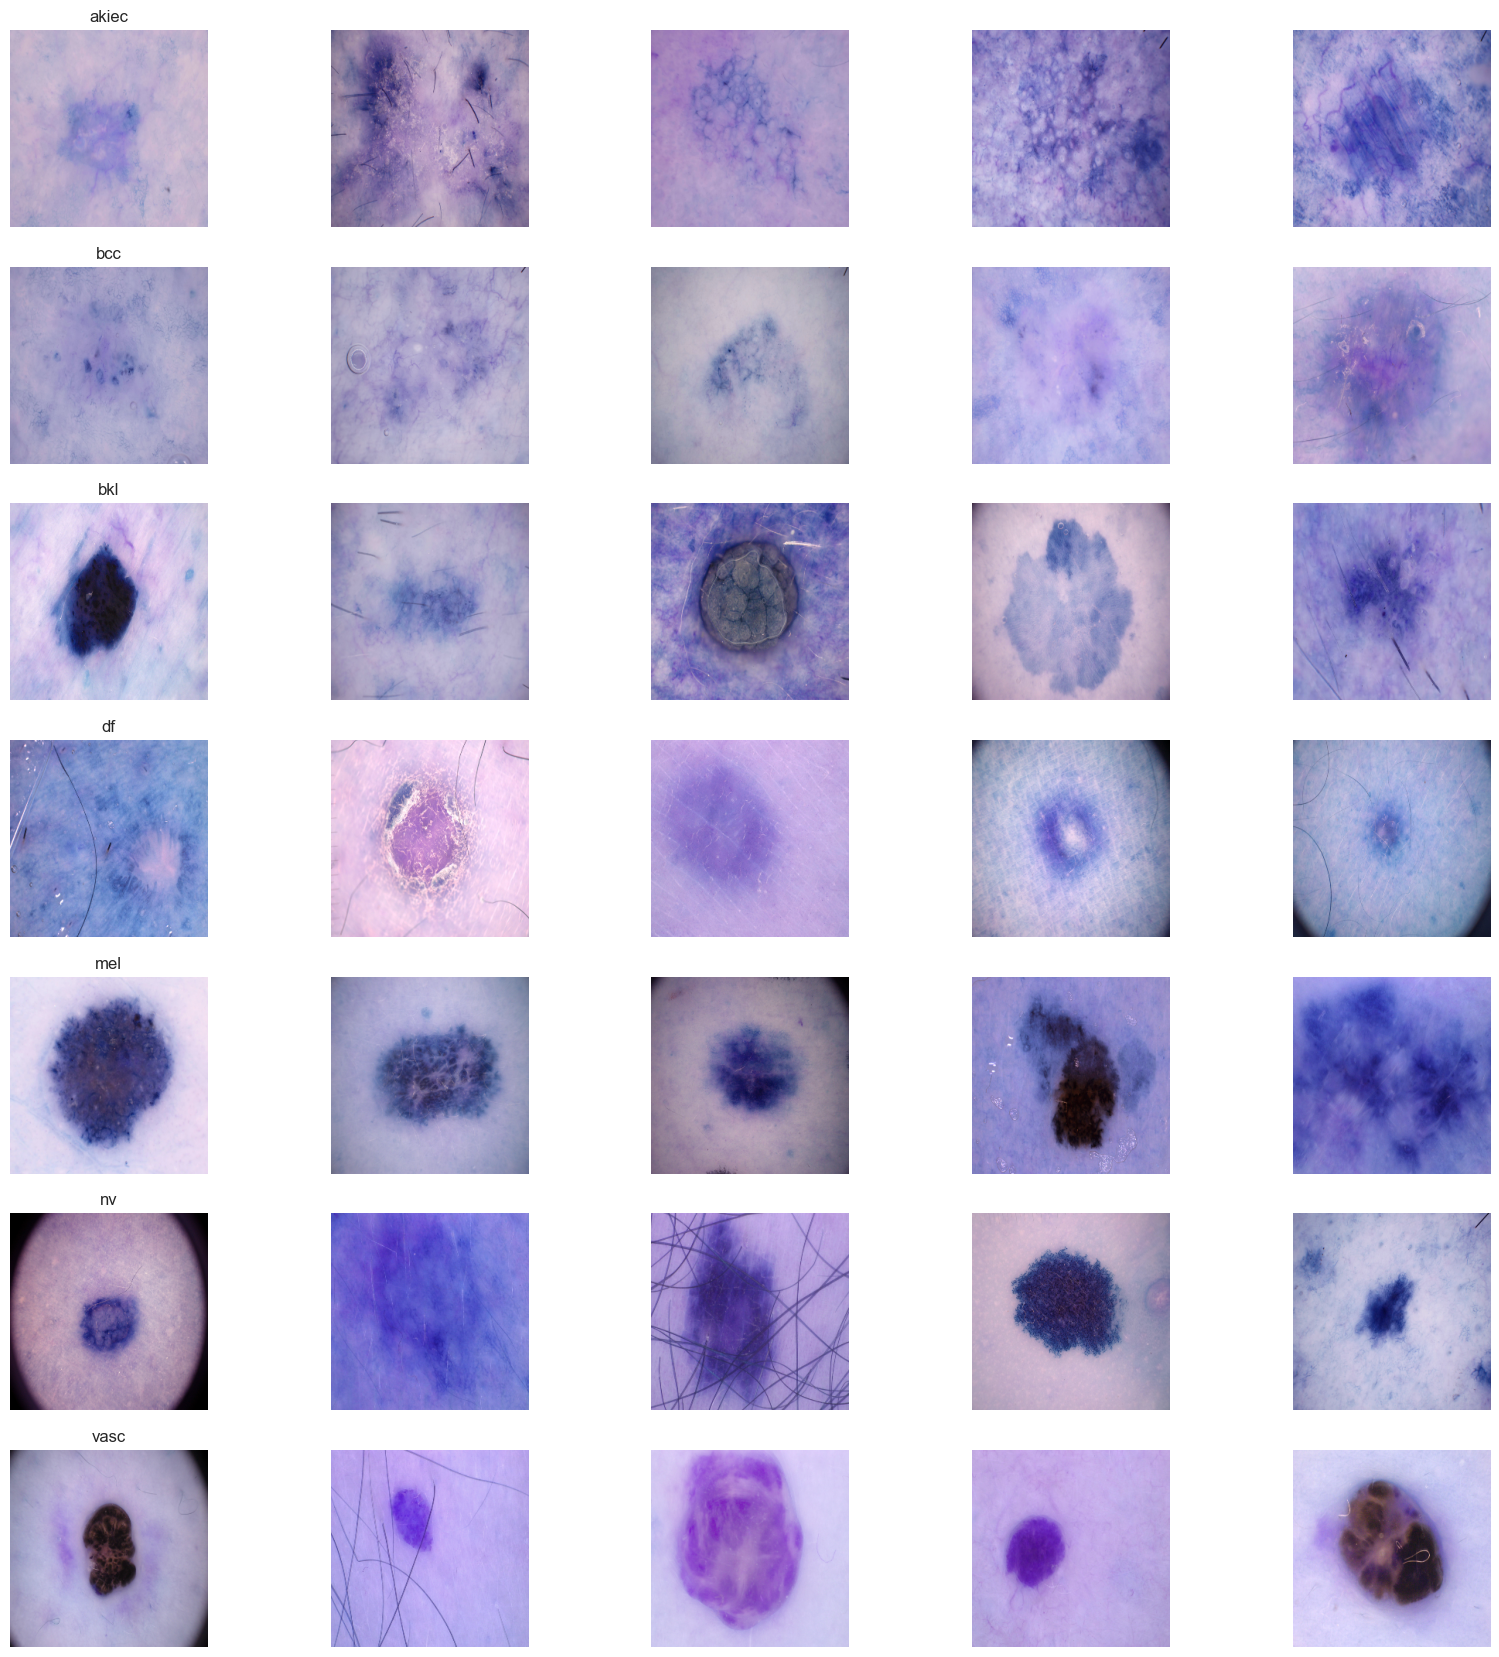

In [17]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, Metadata.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# ONE HOT ENCODING

In [18]:
from sklearn.preprocessing import OneHotEncoder

# Creating the One Hot Encoder
one_hot_encoder = OneHotEncoder(sparse=False)

# One Hot Encoding the dx column
one_hot_encoded_Y = one_hot_encoder.fit_transform(Metadata['dx'].values.reshape(-1,1))

c:\Users\hasan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
from sklearn.model_selection import train_test_split
X = np.zeros((len(Metadata),256,256,3))
for i in range(len(Metadata)):
    X[i] = Metadata['image'][i]

# Splitting the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,one_hot_encoded_Y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training set shape:", Y_train.shape)
print("Testing set shape:", Y_test.shape)

Training set shape: (8012, 256, 256, 3)
Testing set shape: (2003, 256, 256, 3)
Training set shape: (8012, 7)
Testing set shape: (2003, 7)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten, MaxPool2D 
import keras.backend as K


# Creating A Simple CNN Model with attention layer
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256,256,3), name='conv2d_1', padding='same'))
model.add(MaxPool2D((2, 2), name='max_pool2d_1'))
model.add(Conv2D(32, (3, 3), activation='relu', name='conv2d_2'))
model.add(MaxPool2D((2, 2), name='max_pool2d_2'))
model.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_3'))
model.add(MaxPool2D((2, 2), name='max_pool2d_3'))
model.add(GlobalAveragePooling2D(name='GlobalAveragePooling2D'))
model.add(Dense(32, activation='relu', name='dense_1'))
model.add(Dense(7, activation='softmax', name='dense_2'))

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pool2d_1 (MaxPooling2D)  (None, 128, 128, 16)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      4640      
                                                                 
 max_pool2d_2 (MaxPooling2D)  (None, 63, 63, 32)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pool2d_3 (MaxPooling2D)  (None, 30, 30, 64)       0         
                                                                 
 GlobalAveragePooling2D (Glo  (None, 64)              

In [23]:
# Training the model with early stopping and model checkpoint callbacks
filepath = "./CNN_model_checkpoint.h5"

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val-loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
history = model.fit(X_train, Y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 1.0810 - accuracy: 0.6694
Epoch 1: saving model to .\CNN_model_checkpoint.h5
51/51 [==============================] - 107s 2s/step - loss: 1.0810 - accuracy: 0.6694 - val_loss: 1.0521 - val_accuracy: 0.6719
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 1.0595 - accuracy: 0.6694
Epoch 2: saving model to .\CNN_model_checkpoint.h5
51/51 [==============================] - 95s 2s/step - loss: 1.0595 - accuracy: 0.6694 - val_loss: 1.0453 - val_accuracy: 0.6719
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 1.0476 - accuracy: 0.6694
Epoch 3: saving model to .\CNN_model_checkpoint.h5
51/51 [==============================] - 96s 2s/step - loss: 1.0476 - accuracy: 0.6694 - val_loss: 1.0276 - val_accuracy: 0.6719
Epoch 4/10
51/51 [==============================] - ETA: 0s - loss: 1.0295 - accuracy: 0.6694
Epoch 4: saving model to .\CNN_model_checkpoint.h5
51/51 [=========================

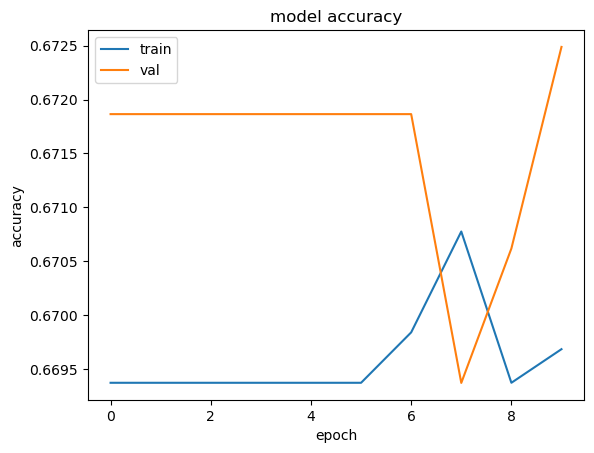

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)
# Evaluating the model
from sklearn.metrics import accuracy_score, confusion_matrix
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

63/63 [==============================] - 6s 101ms/step
Accuracy Score:  0.6684972541188218
Confusion Matrix: 
 [[   0    2    1    0    0   66    0]
 [   0    0    2    0    0   91    0]
 [   0    5    4    0    0  219    0]
 [   0    0    0    0    0   28    0]
 [   0    0    2    0    1  223    0]
 [   0    0    2    0    2 1334    0]
 [   0    0    0    0    0   21    0]]


In [28]:
# f1 score
from sklearn.metrics import f1_score
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))

F1 Score:  0.5416084587459464


# Second Model with EfficientNetB1 - Transfer Learning

In [6]:
base_model = tf.keras.applications.EfficientNetB1(input_shape=(256,256,3), include_top=False, 
                                                  weights='imagenet', pooling='max')
base_model.trainable = False
inputs = keras.Input(shape=(256,256,3))
x= base_model(inputs, training=False)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Dense(128, activation='relu')(x)
x=keras.layers.Dropout(0.5, seed=12)(x)
output = keras.layers.Dense(7,activation='softmax')(x)
Transfer_model = keras.Model(inputs=inputs, outputs=output)
Transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                             

In [46]:
filepath = "./EfficientNetB1_model_checkpoint.h5"

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val-loss', verbose=1, save_best_only=False, 
                             save_weights_only=True, mode='auto', period=1)
history = Transfer_model.fit(X_train, Y_train, epochs=10, batch_size=128, validation_split=0.2, 
                             callbacks=[checkpoint, early_stopping])

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 1.0208 - accuracy: 0.6619
Epoch 1: saving model to .\EfficientNetB1_model_checkpoint.h5
51/51 [==============================] - 322s 6s/step - loss: 1.0208 - accuracy: 0.6619 - val_loss: 17.3937 - val_accuracy: 0.6719
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 1.0061 - accuracy: 0.6602
Epoch 2: saving model to .\EfficientNetB1_model_checkpoint.h5
51/51 [==============================] - 345s 7s/step - loss: 1.0061 - accuracy: 0.6602 - val_loss: 13.3689 - val_accuracy: 0.6719
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 0.9613 - accuracy: 0.6661
Epoch 3: saving model to .\EfficientNetB1_model_checkpoint.h5
51/51 [==============================] - 345s 7s/step - loss: 0.9613 - accuracy: 0.6661 - val_loss: 12.2019 - val_accuracy: 0.6719
Epoch 4/10
51/51 [==============================] - ETA: 0s - loss: 0.9687 - accuracy: 0.6647
Epoch 4: saving model to .\EfficientNetB1_mod

In [30]:
X_test.shape

(2003, 75, 100, 3)

63/63 [==============================] - 97s 1s/step
Accuracy Score:  0.6684972541188218
Confusion Matrix: 
 [[   0    0    0    0    0   69    0]
 [   0    0    0    0    0   93    0]
 [   0    0    1    0    0  227    0]
 [   0    0    0    0    0   28    0]
 [   0    0    0    0    0  226    0]
 [   0    0    0    0    0 1338    0]
 [   0    0    0    0    0   21    0]]
F1 Score:  0.5361925419795939
Precision Score:  0.5602734759000361
Recall Score:  0.6684972541188218


c:\Users\hasan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


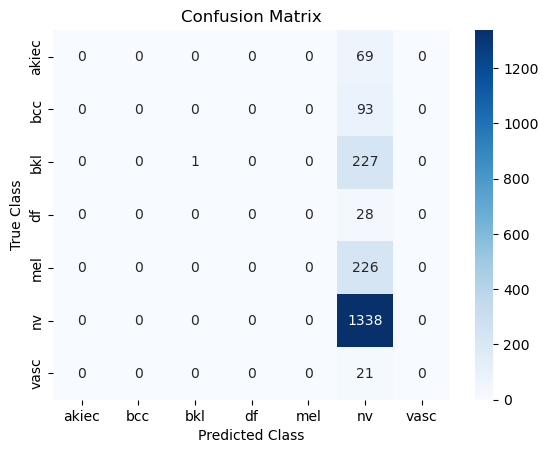

In [7]:
from tensorflow.keras.models import load_model

# Loading the saved model
Transfer_model.load_weights('./EfficientNetB1_model_checkpoint.h5')

y_pred = Transfer_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)
# Evaluating the model
from sklearn.metrics import accuracy_score, confusion_matrix
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
print('Precision Score: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall Score: ', recall_score(y_test, y_pred, average='weighted'))
conf = confusion_matrix(y_test, y_pred)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
conf_df = pd.DataFrame(conf, index=class_names, columns=class_names)
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


# Changing the image Size

In [2]:
#Initialize the Image List
Image_List = []

for path_dir, dir_names, filenames in os.walk(path_to_Image_Folder):
    # Loop over the sub directories to get the images
    for filename in filenames:
        # Check if the image is a jpg file
        if filename.endswith('.jpg'):
            # Read the image using cv2
            img = cv2.imread(os.path.join(path_dir, filename), cv2.IMREAD_UNCHANGED)
            img = np.array(img)

            #Normalizing the image
            img = img/255.0

            # Resizing the image to (256,256,3)
            img = cv2.resize(img, (100,75))

            # Appending the image to the list
            Image_List.append([filename.split('.')[0],img])

# Converting the Image List to a numpy array
Image_List = np.array(Image_List)

# Converting the Image List to a dataframe
Image_List = pd.DataFrame({'image_id':Image_List[:,0],'image':Image_List[:,1]})
print(Image_List.head())
print(Image_List.shape)

C:\Users\hasan\AppData\Local\Temp\ipykernel_16172\3685636046.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Image_List = np.array(Image_List)


       image_id                                              image
0  ISIC_0024306  [[[0.5245098039215687, 0.5117647058823529, 0.9...
1  ISIC_0024307  [[[0.5166666666666666, 0.47352941176470587, 0....
2  ISIC_0024308  [[[0.7215686274509804, 0.6833333333333333, 0.9...
3  ISIC_0024309  [[[0.5205882352941176, 0.4549019607843137, 0.8...
4  ISIC_0024310  [[[0.14509803921568626, 0.12941176470588234, 0...
(10015, 2)


In [3]:
# Merging the Metadata and Image Dataframes
Metadata = Metadata.merge(Image_List, on='image_id', how='inner')
Metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,"[[[0.7627450980392156, 0.6029411764705882, 0.7..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,"[[[0.08431372549019608, 0.048039215686274506, ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,"[[[0.5333333333333333, 0.4931372549019608, 0.7..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,"[[[0.07254901960784313, 0.04607843137254902, 0..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,"[[[0.4411764705882353, 0.3529411764705882, 0.5..."


In [50]:
Metadata['image'][0].shape

(75, 100, 3)

In [8]:
from sklearn.model_selection import train_test_split
X = np.zeros((len(Metadata),75,100,3))
for i in range(len(Metadata)):
    X[i] = Metadata['image'][i]

# Splitting the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X,one_hot_encoded_Y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training set shape:", Y_train.shape)
print("Testing set shape:", Y_test.shape)

Training set shape: (8012, 75, 100, 3)
Testing set shape: (2003, 75, 100, 3)
Training set shape: (8012, 7)
Testing set shape: (2003, 7)


In [65]:
base_model = tf.keras.applications.EfficientNetB1(input_shape=(75,100,3), include_top=False, 
                                                  weights='imagenet', pooling='max')
inputs = keras.Input(shape=(75,100,3))
x= base_model(inputs, training=True)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Dense(128, activation='relu')(x)
x=keras.layers.Dropout(0.5, seed=12)(x)
output = keras.layers.Dense(7,activation='softmax')(x)
Transfer_model_new = keras.Model(inputs=inputs, outputs=output)
Transfer_model_new.compile(optimizer=Adamax(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
Transfer_model_new.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 75, 100, 3)]      0         
                                                                 
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 batch_normalization_10 (Bat  (None, 1280)             5120      
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 128)               163968    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 7)                 903       
                                                           

In [68]:
filepath = "./EfficientNetB1_model_new_checkpoint.h5"

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val-loss', verbose=1, save_best_only=False, 
                             save_weights_only=True, mode='auto', period=1)
history = Transfer_model_new.fit(X_train, Y_train, epochs=10, batch_size=128, validation_split=0.2, 
                             callbacks=[checkpoint, early_stopping])

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 1.5488 - accuracy: 0.5469
Epoch 1: saving model to .\EfficientNetB1_model_new_checkpoint.h5
51/51 [==============================] - 264s 5s/step - loss: 1.5488 - accuracy: 0.5469 - val_loss: 1.0959 - val_accuracy: 0.6906
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 1.0023 - accuracy: 0.6595
Epoch 2: saving model to .\EfficientNetB1_model_new_checkpoint.h5
51/51 [==============================] - 247s 5s/step - loss: 1.0023 - accuracy: 0.6595 - val_loss: 0.8592 - val_accuracy: 0.7149
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 0.8404 - accuracy: 0.7042
Epoch 3: saving model to .\EfficientNetB1_model_new_checkpoint.h5
51/51 [==============================] - 252s 5s/step - loss: 0.8404 - accuracy: 0.7042 - val_loss: 0.8008 - val_accuracy: 0.7411
Epoch 4/10
51/51 [==============================] - ETA: 0s - loss: 0.7552 - accuracy: 0.7338
Epoch 4: saving model to .\Efficient

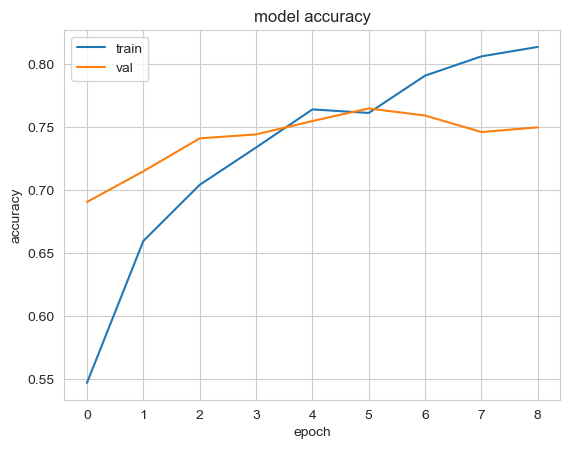

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

63/63 [==============================] - 29s 459ms/step
Accuracy Score:  0.7563654518222666


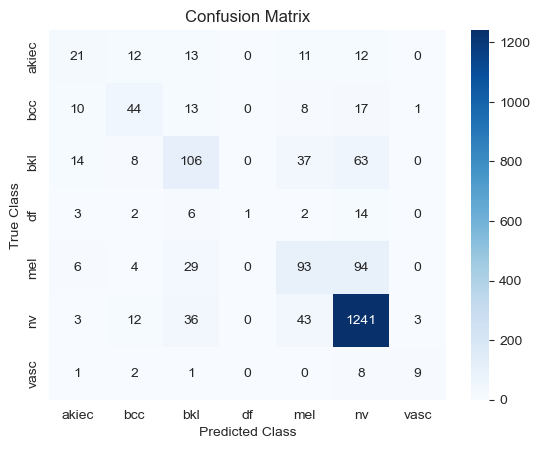

In [73]:
y_pred = Transfer_model_new.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)
# Evaluating the model
from sklearn.metrics import accuracy_score, confusion_matrix
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
conf = confusion_matrix(y_test, y_pred)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
conf_df = pd.DataFrame(conf, index=class_names, columns=class_names)
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [74]:

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       akiec       0.36      0.30      0.33        69
         bcc       0.52      0.47      0.50        93
         bkl       0.52      0.46      0.49       228
          df       1.00      0.04      0.07        28
         mel       0.48      0.41      0.44       226
          nv       0.86      0.93      0.89      1338
        vasc       0.69      0.43      0.53        21

    accuracy                           0.76      2003
   macro avg       0.63      0.44      0.46      2003
weighted avg       0.74      0.76      0.74      2003



# Fusing EfficientNetB1 and ConvNextBase

In [10]:
# Transfer learning using ConvNeXtBase
base_model_2 = tf.keras.applications.ConvNeXtBase(input_shape=(75,100,3), include_top=False,weights='imagenet', pooling='max')
Inputs_2 = keras.Input(shape=(75,100,3))
base_model_2.trainable = False
x_2= base_model_2(Inputs_2, training=False)
x_2=keras.layers.BatchNormalization()(x_2)
x_2=keras.layers.Dense(128, activation='relu')(x_2)
x_2=keras.layers.Dropout(0.5, seed=12)(x_2)
output_2 = keras.layers.Dense(7,activation='softmax')(x_2)
Transfer_model_new_2 = keras.Model(inputs=Inputs_2, outputs=output_2)
Transfer_model_new_2.compile(optimizer=Adamax(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
Transfer_model_new_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 100, 3)]      0         
                                                                 
 convnext_base (Functional)  (None, 1024)              87566464  
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                             

In [ ]:
# Intended to be used as Fusion Model
mergedOut = keras.layers.concatenate([Transfer_model.output, Transfer_model_new_2.output])
final_output = keras.layers.Dense(7, activation='softmax')(mergedOut)
Fused_model = keras.Model([Transfer_model.input, Transfer_model_new_2.input], final_output)
Fused_model.compile(optimizer=Adamax(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
Fused_model.summary()

In [11]:
filepath = "./ConvNextBase_model_checkpoint.h5"

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val-loss', verbose=1, save_best_only=False, 
                             save_weights_only=True, mode='auto', period=1)
history_Fused = Transfer_model_new_2.fit(X_train, Y_train, epochs=10, batch_size=128, validation_split=0.2, 
                             callbacks=[checkpoint, early_stopping])

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 1.4887 - accuracy: 0.6021 
Epoch 1: saving model to .\ConvNextBase_model_checkpoint.h5
51/51 [==============================] - 905s 18s/step - loss: 1.4887 - accuracy: 0.6021 - val_loss: 1.9502 - val_accuracy: 0.1410
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 1.2068 - accuracy: 0.6525 
Epoch 2: saving model to .\ConvNextBase_model_checkpoint.h5
51/51 [==============================] - 839s 16s/step - loss: 1.2068 - accuracy: 0.6525 - val_loss: 1.6446 - val_accuracy: 0.6213
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 1.1485 - accuracy: 0.6628 
Epoch 3: saving model to .\ConvNextBase_model_checkpoint.h5
51/51 [==============================] - 939s 19s/step - loss: 1.1485 - accuracy: 0.6628 - val_loss: 1.4779 - val_accuracy: 0.6818
Epoch 4/10
51/51 [==============================] - ETA: 0s - loss: 1.0932 - accuracy: 0.6683 
Epoch 4: saving model to .\ConvNextBase_model_c

KeyboardInterrupt: 

In [5]:
# Create another CNN model instance
Inputs_3 = keras.Input(shape=(75,100,3))
x_3 = keras.layers.Conv2D(32, (7, 7), activation='relu', name= 'Conv2d_1')(Inputs_3)
x_3 = keras.layers.MaxPooling2D((2, 2),  name= 'MaxPool2d_1')(x_3)
x_3 = keras.layers.Conv2D(64, (4, 4), activation='relu', name= 'Conv2d_2')(x_3)
x_3 = keras.layers.Conv2D(64, (4, 4), activation='relu', name= 'Conv2d_3')(x_3)
x_3 = keras.layers.MaxPooling2D((2, 2),  name= 'MaxPool2d_2')(x_3)
x_3 = keras.layers.Conv2D(128, (3, 3), activation='relu', name= 'Conv2d_4')(x_3)
x_3 = keras.layers.Conv2D(128, (3, 3), activation='relu', name= 'Conv2d_5')(x_3)
x_3 = keras.layers.Conv2D(128, (3, 3), activation='relu', name= 'Conv2d_6')(x_3)
x_3 = keras.layers.MaxPooling2D((2, 2),  name= 'MaxPool2d_3')(x_3)
x_3 = tf.keras.layers.GlobalAveragePooling2D(name='avgpool')(x_3)
x_3 = keras.layers.Dense(64, activation='relu',  name= 'Dense_1')(x_3)
x_3 = keras.layers.Dense(32,activation='relu',  name= 'Dense_2')(x_3)
x_3 = keras.layers.Dense(16,activation='relu',  name= 'Dense_3')(x_3)
output_3 = keras.layers.Dense(7, activation='softmax',  name= 'Dense_Output')(x_3)

model_3 = keras.Model(Inputs_3, output_3)
model_3.compile(optimizer=Adamax(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 100, 3)]      0         
                                                                 
 Conv2d_1 (Conv2D)           (None, 69, 94, 32)        4736      
                                                                 
 MaxPool2d_1 (MaxPooling2D)  (None, 34, 47, 32)        0         
                                                                 
 Conv2d_2 (Conv2D)           (None, 31, 44, 64)        32832     
                                                                 
 Conv2d_3 (Conv2D)           (None, 28, 41, 64)        65600     
                                                                 
 MaxPool2d_2 (MaxPooling2D)  (None, 14, 20, 64)        0         
                                                                 
 Conv2d_4 (Conv2D)           (None, 12, 18, 128)       73856 

In [9]:
filepath = "./Model_3_checkpoint.h5"

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val-loss', verbose=1, save_best_only=False, 
                             save_weights_only=True, mode='auto', period=1)
history_model_3 = model_3.fit(X_train, Y_train, epochs=10, batch_size=128, validation_split=0.2, 
                             callbacks=[checkpoint, early_stopping])

Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 1.1814 - accuracy: 0.6661
Epoch 1: saving model to .\Model_3_checkpoint.h5
51/51 [==============================] - 37s 709ms/step - loss: 1.1814 - accuracy: 0.6661 - val_loss: 1.0323 - val_accuracy: 0.6719
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 1.0289 - accuracy: 0.6694
Epoch 2: saving model to .\Model_3_checkpoint.h5
51/51 [==============================] - 37s 730ms/step - loss: 1.0289 - accuracy: 0.6694 - val_loss: 1.0142 - val_accuracy: 0.6719
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 1.0087 - accuracy: 0.6694
Epoch 3: saving model to .\Model_3_checkpoint.h5
51/51 [==============================] - 39s 760ms/step - loss: 1.0087 - accuracy: 0.6694 - val_loss: 0.9880 - val_accuracy: 0.6719
Epoch 4/10
51/51 [==============================] - ETA: 0s - loss: 1.0039 - accuracy: 0.6694
Epoch 4: saving model to .\Model_3_checkpoint.h5
51/51 [=========================

# Rehandling the Data Processing for creating DataLoaders for PyTorch Models

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from efficientnet_pytorch import EfficientNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import time

class HAM10000Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        # Initialize one-hot encoder
        self.onehot_encoder = OneHotEncoder(sparse=False)

        # Fit one-hot encoder to the labels
        labels = self.annotations['dx'].values.reshape(-1, 1)
        self.onehot_encoder.fit(labels)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 1] + '.jpg')
        image = Image.open(img_name)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Extract label and apply one-hot encoding
        label = self.annotations.iloc[idx, 2]
        label_encoded = self.onehot_encoder.transform([[label]])[0]
        label_tensor = torch.tensor(label_encoded, dtype=torch.float32)

        return image, label_tensor

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
csv_file = r'Data\HAM10000_metadata.csv'  # Path to the CSV file containing image paths and labels
root_dir = r'Data'  # Path to the folder containing images

metadata = pd.read_csv(csv_file)
dataset = HAM10000Dataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# Split dataset into train and test sets (80% train, 20% test)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Split dataset into train and validation sets (%80 train, %20 validation)
train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

c:\Users\hasan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import time
# Define the model using EfficientNet
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=7):
        super(EfficientNetModel, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b3')
        self.model._fc = nn.Linear(self.model._fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)
torch.manual_seed(42)
# Initialize model, loss function, and optimizer
model = EfficientNetModel(num_classes=7)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)



Loaded pretrained weights for efficientnet-b3


In [4]:
def train(model, criterion, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        _, targets = torch.max(labels, 1) # Get the index of the maximum value for labels
        total += labels.size(0)
        correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def validate(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            _, targets = torch.max(labels, 1) # Get the index of the maximum value for labels
            total += labels.size(0)
            correct += (predicted == targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy


Epoch [1/50], Train Loss: 1.1815, Train Accuracy: 0.6389, Val Loss: 0.8523, Val Accuracy: 0.7043
Epoch [2/50], Train Loss: 0.6508, Train Accuracy: 0.7730, Val Loss: 0.5910, Val Accuracy: 0.7891
Epoch [3/50], Train Loss: 0.4291, Train Accuracy: 0.8513, Val Loss: 0.5160, Val Accuracy: 0.8153
Epoch [4/50], Train Loss: 0.2679, Train Accuracy: 0.9092, Val Loss: 0.6257, Val Accuracy: 0.7948
Epoch [5/50], Train Loss: 0.2072, Train Accuracy: 0.9276, Val Loss: 0.6664, Val Accuracy: 0.7779
Epoch [6/50], Train Loss: 0.1826, Train Accuracy: 0.9354, Val Loss: 0.6550, Val Accuracy: 0.8216
Epoch [7/50], Train Loss: 0.1783, Train Accuracy: 0.9360, Val Loss: 0.8346, Val Accuracy: 0.7848
Epoch [8/50], Train Loss: 0.1784, Train Accuracy: 0.9391, Val Loss: 0.8773, Val Accuracy: 0.8010
Epoch [9/50], Train Loss: 0.1744, Train Accuracy: 0.9407, Val Loss: 0.6762, Val Accuracy: 0.8185
Epoch [10/50], Train Loss: 0.1683, Train Accuracy: 0.9454, Val Loss: 0.6496, Val Accuracy: 0.7711
Epoch [11/50], Train Loss: 0.

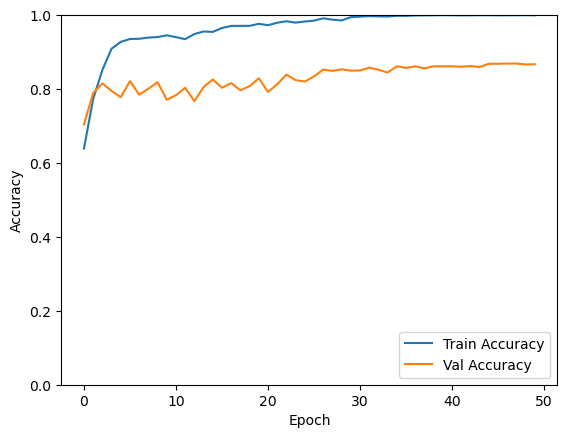

In [5]:
from torch.optim.lr_scheduler import OneCycleLR

# Early stopping parameters
early_stopping_patience = 10
early_stopping_counter = 0
best_val_loss = float('inf')
best_val_accuracy = 0.0

num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Calculate total steps
total_steps = len(train_dataloader) * num_epochs

# Initialize the OneCycleLR scheduler
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=num_epochs)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Step the scheduler
        scheduler.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        _, targets = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == targets).sum().item()
        
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    val_loss, val_accuracy = validate(model, criterion, val_dataloader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss or val_accuracy > best_val_accuracy:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_efficientNet_model.pth')
    else:
        early_stopping_counter += 1
        
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(torch.load('best_efficientNet_model.pth'))

# Evaluate on test set
test_loss, test_accuracy = validate(model, criterion, test_dataloader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Visualize training results
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.projection = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.randn((img_size // patch_size) ** 2, emb_size))

    def forward(self, x):
        x = self.projection(x).flatten(2).transpose(1, 2)
        x += self.position_embeddings
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.unify_heads = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        batch_size, tokens, emb_size = x.size()
        h = self.num_heads
        queries = self.queries(x).view(batch_size, tokens, h, emb_size // h).transpose(1, 2)
        keys = self.keys(x).view(batch_size, tokens, h, emb_size // h).transpose(1, 2)
        values = self.values(x).view(batch_size, tokens, h, emb_size // h).transpose(1, 2)

        attention_scores = torch.einsum('bhqd, bhkd -> bhqk', [queries, keys]) / (emb_size ** (1/2))
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention = torch.einsum('bhal, bhlv -> bhav', [attention_weights, values])
        attention = attention.transpose(1, 2).contiguous().view(batch_size, tokens, emb_size)
        return self.unify_heads(attention)

class TransformerBlock(nn.Module):
    def __init__(self, emb_size, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadSelfAttention(emb_size, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, emb_size),
            nn.Dropout(dropout)
        )
        self.layernorm1 = nn.LayerNorm(emb_size)
        self.layernorm2 = nn.LayerNorm(emb_size)

    def forward(self, x):
        attention_output = self.attention(self.layernorm1(x))
        x = x + attention_output
        mlp_output = self.mlp(self.layernorm2(x))
        return x + mlp_output

class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=10, emb_size=768, num_layers=12, num_heads=12, mlp_dim=3072, dropout=0.1):
        super(ViT, self).__init__()
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.transformer = nn.Sequential(
            *[TransformerBlock(emb_size, num_heads, mlp_dim, dropout) for _ in range(num_layers)]
        )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.mlp_head(x)

# Model hyperparameters
image_size = 224
patch_size = 16
num_classes = len(metadata['dx'].unique())
emb_size = 64
num_heads = 4
num_layers = 8
mlp_dim = 128
dropout = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit_model = ViT(img_size=image_size, patch_size=patch_size, num_classes=num_classes, emb_size=emb_size, num_layers=num_layers, num_heads=num_heads, mlp_dim=mlp_dim, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)


Epoch [1/42], Train Loss: 0.1108, Train Accuracy: 0.9632, Val Loss: 0.9703, Val Accuracy: 0.7486
Epoch [2/42], Train Loss: 0.0715, Train Accuracy: 0.9808, Val Loss: 1.0455, Val Accuracy: 0.7530
Epoch [3/42], Train Loss: 0.0577, Train Accuracy: 0.9838, Val Loss: 1.0837, Val Accuracy: 0.7480
Epoch [4/42], Train Loss: 0.0525, Train Accuracy: 0.9867, Val Loss: 1.2161, Val Accuracy: 0.7511
Epoch [5/42], Train Loss: 0.0638, Train Accuracy: 0.9774, Val Loss: 1.2810, Val Accuracy: 0.7187
Epoch [6/42], Train Loss: 0.1008, Train Accuracy: 0.9627, Val Loss: 1.1321, Val Accuracy: 0.7511
Epoch [7/42], Train Loss: 0.1201, Train Accuracy: 0.9572, Val Loss: 1.2762, Val Accuracy: 0.7405
Epoch [8/42], Train Loss: 0.1714, Train Accuracy: 0.9384, Val Loss: 1.1318, Val Accuracy: 0.7324
Epoch [9/42], Train Loss: 0.1532, Train Accuracy: 0.9445, Val Loss: 1.1130, Val Accuracy: 0.7280
Epoch [10/42], Train Loss: 0.1647, Train Accuracy: 0.9370, Val Loss: 1.1266, Val Accuracy: 0.7311
Epoch [11/42], Train Loss: 0.

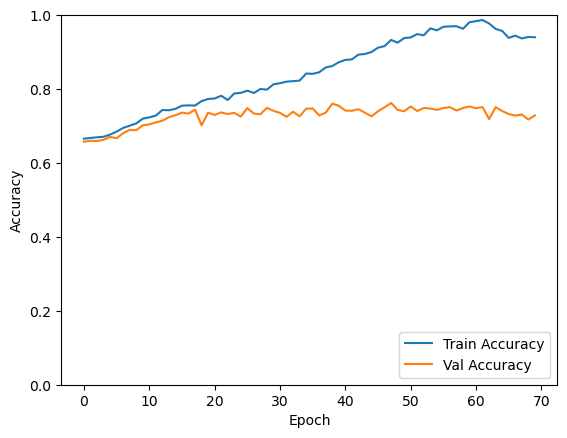

In [8]:
from torch.optim.lr_scheduler import OneCycleLR

# Early stopping parameters
early_stopping_patience = 10
early_stopping_counter = 0
best_val_loss = float('inf')
best_val_accuracy = 0.0

num_epochs = 42
#train_losses, val_losses = [], []
#train_accuracies, val_accuracies = [], []

# Initialize the optimizer
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

# Calculate total steps
total_steps = len(train_dataloader) * num_epochs

# Initialize the OneCycleLR scheduler
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=num_epochs)

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vit_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Step the scheduler
        scheduler.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        _, targets = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == targets).sum().item()
        
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    val_loss, val_accuracy = validate(vit_model, criterion, val_dataloader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss or val_accuracy > best_val_accuracy:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
        early_stopping_counter = 0
        # Save the best model
        torch.save(vit_model.state_dict(), 'best_vit_model.pth')
    else:
        early_stopping_counter += 1
        
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

# Load the best model
vit_model.load_state_dict(torch.load('best_vit_model.pth'))

# Evaluate on test set
test_loss, test_accuracy = validate(vit_model, criterion, test_dataloader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Visualize training results
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import OneCycleLR

# Get back to this section later there is an error for dimension handling in the attention mask

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)

        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout)
        self.drop_path = nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )

    def calculate_mask(self, x):
        B, L, C = x.shape
        H, W = self.input_resolution
        img_mask = torch.zeros((1, H, W, 1)).to(x.device)  # 1 H W 1

        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = self.window_partition(img_mask)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        return attn_mask

    def window_partition(self, x):
        B, H, W, C = x.shape
        x = x.view(B, H // self.window_size, self.window_size, W // self.window_size, self.window_size, C)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, self.window_size, self.window_size, C)
        return windows

    def window_reverse(self, windows, H, W):
        B = int(windows.shape[0] / (H * W / self.window_size / self.window_size))
        x = windows.view(B, H // self.window_size, W // self.window_size, self.window_size, self.window_size, -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
        return x

    def forward(self, x):
        B, L, C = x.shape
        H, W = self.input_resolution

        assert L == H * W, "Input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
            attn_mask = self.calculate_mask(x)
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = self.window_partition(shifted_x).view(-1, self.window_size * self.window_size, C)
        attn_windows, _ = self.attn(x_windows, x_windows, x_windows, attn_mask)
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)

        # merge windows
        shifted_x = self.window_reverse(attn_windows, H, W)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

class SwinTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=7, embed_dim=96, depths=(2, 2, 6, 2),
                 num_heads=(3, 6, 12, 24), window_size=7, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.mlp_ratio = mlp_ratio

        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_drop = nn.Dropout(p=dropout)

        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = nn.ModuleList([SwinTransformerBlock(dim=embed_dim,
                                                        input_resolution=(img_size // patch_size // (2 ** i_layer),
                                                                          img_size // patch_size // (2 ** i_layer)),
                                                        num_heads=num_heads[i_layer],
                                                        window_size=window_size,
                                                        shift_size=0 if (i_layer % 2 == 0) else window_size // 2,
                                                        mlp_ratio=self.mlp_ratio,
                                                        dropout=dropout)
                                   for _ in range(depths[i_layer])])
            self.layers.append(layer)

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.pos_drop(x)

        for layer in self.layers:
            for block in layer:
                x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)

        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_model = SwinTransformer().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(swin_model.parameters(), lr=1e-4)

In [5]:
# Early stopping parameters
early_stopping_patience = 10
early_stopping_counter = 0
best_val_loss = float('inf')
best_val_accuracy = 0.0

num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Initialize the optimizer
optimizer = torch.optim.Adam(swin_model.parameters(), lr=1e-4)

# Calculate total steps
total_steps = len(train_dataloader) * num_epochs

# Initialize the OneCycleLR scheduler
scheduler = OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=num_epochs)

for epoch in range(num_epochs):
    swin_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = swin_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Step the scheduler
        scheduler.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        _, targets = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == targets).sum().item()
        
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    val_loss, val_accuracy = validate(swin_model, criterion, val_dataloader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss or val_accuracy > best_val_accuracy:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
        early_stopping_counter = 0
        # Save the best model
        torch.save(vit_model.state_dict(), 'best_vit_model.pth')
    else:
        early_stopping_counter += 1
        
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

# Load the best model
vit_model.load_state_dict(torch.load('best_vit_model.pth'))

# Evaluate on test set
test_loss, test_accuracy = validate(swin_model, criterion, test_dataloader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Visualize training results
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


AssertionError: Input feature has wrong size